## Environment prep

In [ ]:
!pip install hampel

In [ ]:
from hampel import hampel
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from math import sqrt, atan2

## Load all data into a list of dataframes

In [ ]:
# Specify the path to your main folder
main_folder_path = '/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-raw/sess2'

# Initialize an empty dictionary to store lists of DataFrames for each activity
activity_dataframes = []
label_list = []

# Iterate through subfolders
for activity_folder in os.listdir(main_folder_path):
    activity_folder_path = os.path.join(main_folder_path, activity_folder)
    # Check if it's a directory
    if os.path.isdir(activity_folder_path):
        # Iterate through files in the subfolder
        for file_name in os.listdir(activity_folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_folder_path, file_name)
                label_list.append(activity_folder)
                # Read the data from each CSV file into a DataFrame
                df = pd.read_csv(file_path)
                activity_dataframes.append(df)


In [ ]:
print(len(activity_dataframes))

35


## Extract amplitude from dataframes

In [ ]:
amp_dataframes = []
# Loop through each file
for df in activity_dataframes:
    # Construct the full path to the file
    data = []
    for _, row in df.iterrows():
      imaginary = []
      real = []
      amplitudes = []

        # Parse string to create integer list
      csi_string = re.findall(r"\[(.*)\]", row['CSI_DATA'])[0]
      csi_raw = [int(x) for x in csi_string.split(" ") if x != '']

        # Create list of imaginary and real numbers from CSI
      for i in range(len(csi_raw)):
          if i % 2 == 0:
              imaginary.append(csi_raw[i])
          else:
              real.append(csi_raw[i])

        # Transform imaginary and real into amplitude and phase
      for i in range(int(len(csi_raw) / 2)):
          amplitudes.append(sqrt(imaginary[i] ** 2 + real[i] ** 2))
      data.append(amplitudes)
    temp_df = pd.DataFrame(data)
    amp_dataframes.append(temp_df)



In [ ]:
print(len(amp_dataframes))
print(len(label_list))

35
35


In [ ]:
print(label_list)

['LL', 'LL', 'LL', 'LL', 'LL', 'LA', 'LA', 'LA', 'LA', 'LA', 'JJ', 'JJ', 'JJ', 'JJ', 'JJ', 'RL', 'RL', 'RL', 'RL', 'RL', 'RA', 'RA', 'RA', 'RA', 'RA', 'NA', 'NA', 'NA', 'NA', 'NA', 'SO', 'SO', 'SO', 'SO', 'SO']


In [ ]:
print(amp_dataframes[1].shape)

(5499, 64)


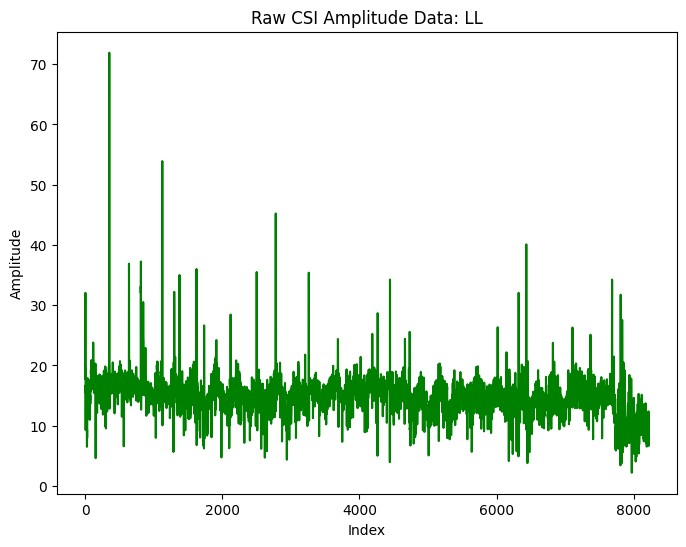

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(amp_dataframes[2][50],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Raw CSI Amplitude Data: LL')
plt.show()

In [ ]:
print(amp_dataframes[2][50].head(10))

0    18.457302
1    19.620071
2    17.701004
3    22.376179
4    26.404198
5    32.046898
6    21.221924
7    11.565775
8     9.276746
9    15.720640
Name: 50, dtype: float32


## Apply noise filter

In [ ]:
denoised_dataframes = []
for amplitude in amp_dataframes:
    filtered_data = pd.DataFrame()
    for col in amplitude.columns:
      col_series = amplitude[col]
      # Hampel filter
      hampel_filtered = hampel(col_series, window_size=10)
      # Savitzky-Golay filter
      sg_filtered = savgol_filter(hampel_filtered.filtered_data, window_length=10, polyorder=3)
      filtered_data[col] = sg_filtered
    denoised_dataframes.append(filtered_data)


In [ ]:
print(len(denoised_dataframes))

35


In [ ]:
path = '/content/drive/MyDrive/Wifi_Exercise_Dataset/tvat-filtered-2/'
for i, dataframe in enumerate(denoised_dataframes):
  filename = f"{label_list[i]}-{i+1}.csv"
  dataframe.to_csv(path+filename, index=False)


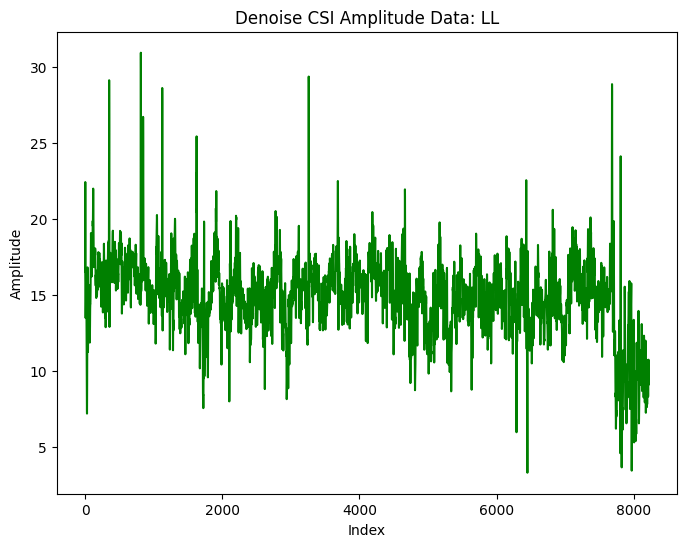

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(denoised_dataframes[2][50],color='g')
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Denoise CSI Amplitude Data: LL')
plt.show()

In [ ]:
print(denoised_dataframes[2][50].head(10))

0    18.698980
1    18.653358
2    19.151073
3    21.561615
4    28.147985
5    28.985281
6    22.202341
7    11.979988
8    10.607816
9    14.241845
Name: 50, dtype: float32


In [ ]:

columns_to_drop = [2,3,4,5,32,59,60,61,62,63]
for df in amp_dataframes:
    df.drop(df.columns[columns_to_drop], axis=1,inplace=True)


## Segmentation

In [ ]:
segment_dataframes = []
labels = []
for i, df in enumerate(amp_dataframes):
  df_len = len(df)
  #df['label'] = label_list[i]
  df.drop(df.columns[-1],axis=1,inplace=True)
  segment_len = (df_len//200)*200
  rows_to_skip = len(df) - segment_len
  rounded_df = df.iloc[rows_to_skip:]
  segment_df = np.array_split(rounded_df, range(200, len(rounded_df), 200))
  for segment in segment_df:
    segment_dataframes.append(segment)
    labels.append(label_list[i])


In [ ]:
print(len(segment_dataframes))
print(len(labels))

1165
1165


In [ ]:
print(segment_dataframes[3])

             0    1          6          7          8          9          10  \
707  105.603027  4.0   8.173367   8.133499   8.326377   8.740322   7.184147   
708  105.603027  4.0   9.278374   9.154801   9.758579   9.858769   8.280706   
709  105.603027  4.0  10.472335  10.105364  11.024837  10.883145   9.284912   
710  105.603027  4.0  11.432827  10.822251  11.795613  11.734648  10.154380   
711  105.603027  4.0  12.009859  11.320781  12.147852  12.627798  11.046046   
..          ...  ...        ...        ...        ...        ...        ...   
902  105.603027  4.0  13.257929  13.591935  13.837964  11.777891  13.320248   
903  105.603027  4.0  13.748153  13.663969  13.645518  12.271646  13.386294   
904  105.603027  4.0  14.052884  13.228633  13.415762  13.017454  13.548595   
905  105.603027  4.0  14.292799  12.408063  13.168546  13.744004  13.720463   
906  105.603027  4.0  14.412230  12.245303  13.675761  14.095879  13.828314   

            11         12         13  ...         4

## CNN Model

In [ ]:
# Convert DataFrames to matrices
matrix_list = [df.values for df in segment_dataframes]

# Stack matrices vertically
stacked_matrix = np.vstack(matrix_list)

In [ ]:
dataset_array = np.concatenate(segment_dataframes, axis=0)

In [ ]:
print(matrix_list.shape)

AttributeError: ignored

In [ ]:
print(stacked_matrix)

[[105.60303    4.         6.57814  ...  12.091852   8.917306  10.116916]
 [105.60303    4.         5.430165 ...  14.221633   9.903031  10.61797 ]
 [105.60303    4.         5.929819 ...  16.012304  10.760431  11.114534]
 ...
 [105.60303    4.        25.059336 ...  10.095553  11.091435  11.671971]
 [105.60303    4.        25.34694  ...   9.564811  11.037096  10.249299]
 [105.60303    4.        26.890959 ...   8.700585  10.980692   7.960748]]


In [ ]:
from sklearn.model_selection import train_test_split
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(segment_dataframes, labels, test_size=0.3, random_state=42)

X_train = np.array(X_train)
X_train = X_train.astype('float32')
X_train /= 255
X_test = np.array(X_test)
X_test = X_test.astype('float32')
X_test /= 255

In [ ]:
print(X_train.shape)

(815, 200, 54)


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout,Attention
from tensorflow.keras.losses import SparseCategoricalCrossentropy


# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, 7, activation='relu' , input_shape=(200, 53,1)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(96, 5, activation='relu'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(7, activation='softmax')

])

# Compile the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 194, 47, 32)       1600      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 97, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 93, 19, 96)        76896     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 46, 9, 96)         0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 39744)             0         
                                                                 
 dense_18 (Dense)            (None, 128)              

In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=8,validation_split=0.2)

Epoch 1/50
82/82 [==============================] - 29s 335ms/step - loss: 1.9464 - accuracy: 0.1472 - val_loss: 1.9474 - val_accuracy: 0.1166
Epoch 2/50
82/82 [==============================] - 25s 300ms/step - loss: 1.9407 - accuracy: 0.1702 - val_loss: 1.9469 - val_accuracy: 0.1595
Epoch 3/50
82/82 [==============================] - 27s 329ms/step - loss: 1.9369 - accuracy: 0.1887 - val_loss: 1.9413 - val_accuracy: 0.1227
Epoch 4/50
82/82 [==============================] - 26s 315ms/step - loss: 1.9442 - accuracy: 0.1610 - val_loss: 1.9435 - val_accuracy: 0.1472
Epoch 5/50
82/82 [==============================] - 26s 315ms/step - loss: 1.9387 - accuracy: 0.1748 - val_loss: 1.9397 - val_accuracy: 0.2086
Epoch 6/50
82/82 [==============================] - 27s 327ms/step - loss: 1.9247 - accuracy: 0.1902 - val_loss: 1.9367 - val_accuracy: 0.1595
Epoch 7/50
82/82 [==============================] - 28s 341ms/step - loss: 1.9233 - accuracy: 0.2025 - val_loss: 1.9261 - val_accuracy: 0.1963